# 1/ Import Libraries

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import sys
import gc
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

# 2/ Define Functions

In [4]:
def list_large_objects(threshold=10 * 1024 * 1024):  # default threshold set to 10MB
    # Force a garbage collection first
    gc.collect()
    
    large_items = []

    for obj in gc.get_objects():
        try:
            size = sys.getsizeof(obj)
            if size > threshold:
                large_items.append((str(type(obj)), size))
        except:
            pass

    # Displaying large objects
    if large_items:
        print("Objects larger than 10MB:")
        for type_str, size in large_items:
            print(f"Type: {type_str}, Size: {size / (1024*1024):.2f} MB")
    else:
        print("No objects larger than 10MB were found.")


def remove_outliers_iqr_custom(df, column_name, multiplier=1.5):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

def plot_boxplots(data):
    plt.figure(figsize=(15,10))
    sns.boxplot(data=data)
    plt.title("Box plots of Each Column in Dataset")
    plt.show()



# 3/ Read Dataset

In [5]:
chunk_size = 500000
file_path = "../data/raw/question1_data.csv"

chunks = pd.read_csv(file_path, chunksize=chunk_size)
# Initialize an empty list to store dataframes (optional)
dfs = []
for chunk in chunks:
    # Process each chunk (if needed). For demonstration, we're simply appending them to a list.
    dfs.append(chunk)
# Concatenate chunks back into a single dataframe.
df = pd.concat(dfs, axis=0)

(1525931, 6)


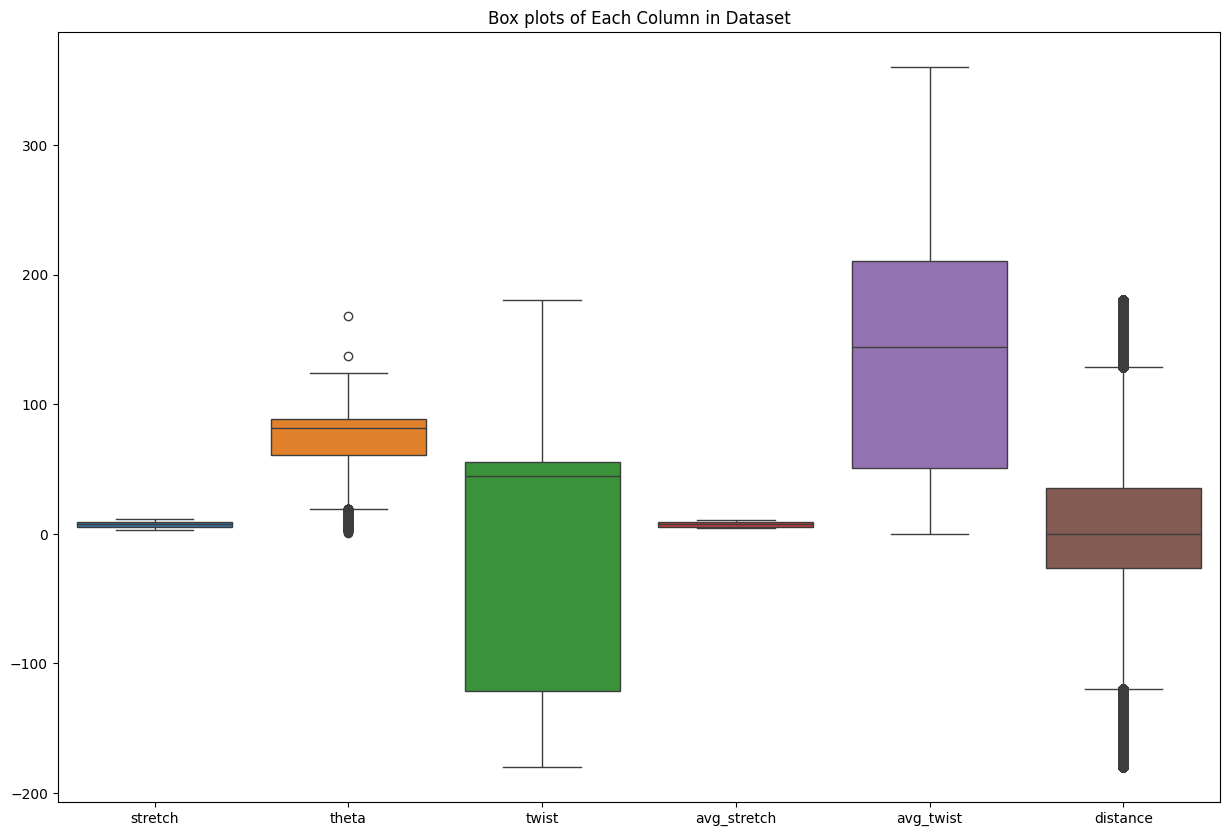

In [6]:
df_id = df["id"]
df = df.drop(columns=["id"])
print(df.shape)

plot_boxplots(data=df)



# 4/ Remove Outliers

In [7]:
# List of columns for which you want to remove outliers
columns_to_remove_outliers = ['stretch', 'theta', 'twist', 'avg_stretch', 'avg_twist', 'distance']

# Specify custom multipliers for specific columns if needed
custom_multipliers = {
    'stretch': 1.5,
    'theta': 1,  # Adjust the multiplier as needed
    'twist': 1.5,
    'avg_stretch': 1.5,
    'avg_twist': 1.5,
    'distance': 1.5  # Adjust the multiplier as needed
}

# Apply the remove_outliers_iqr_custom function to each column with the custom multiplier
for column in columns_to_remove_outliers:
    if column in custom_multipliers:
        df = remove_outliers_iqr_custom(df, column, multiplier=custom_multipliers[column])
    else:
        df = remove_outliers_iqr_custom(df, column)

print(df.shape)

(1237292, 6)


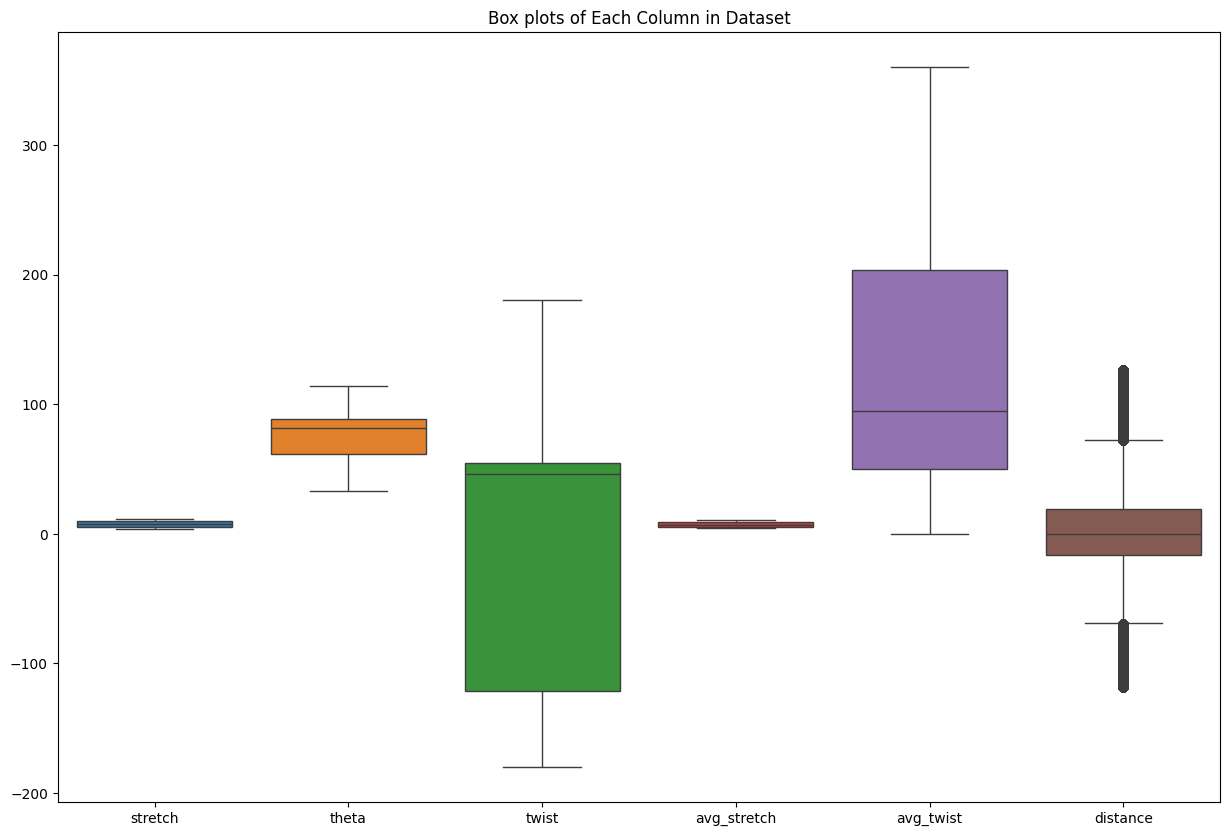

In [8]:
plot_boxplots(data=df)

# 5/ Normalization

In [9]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

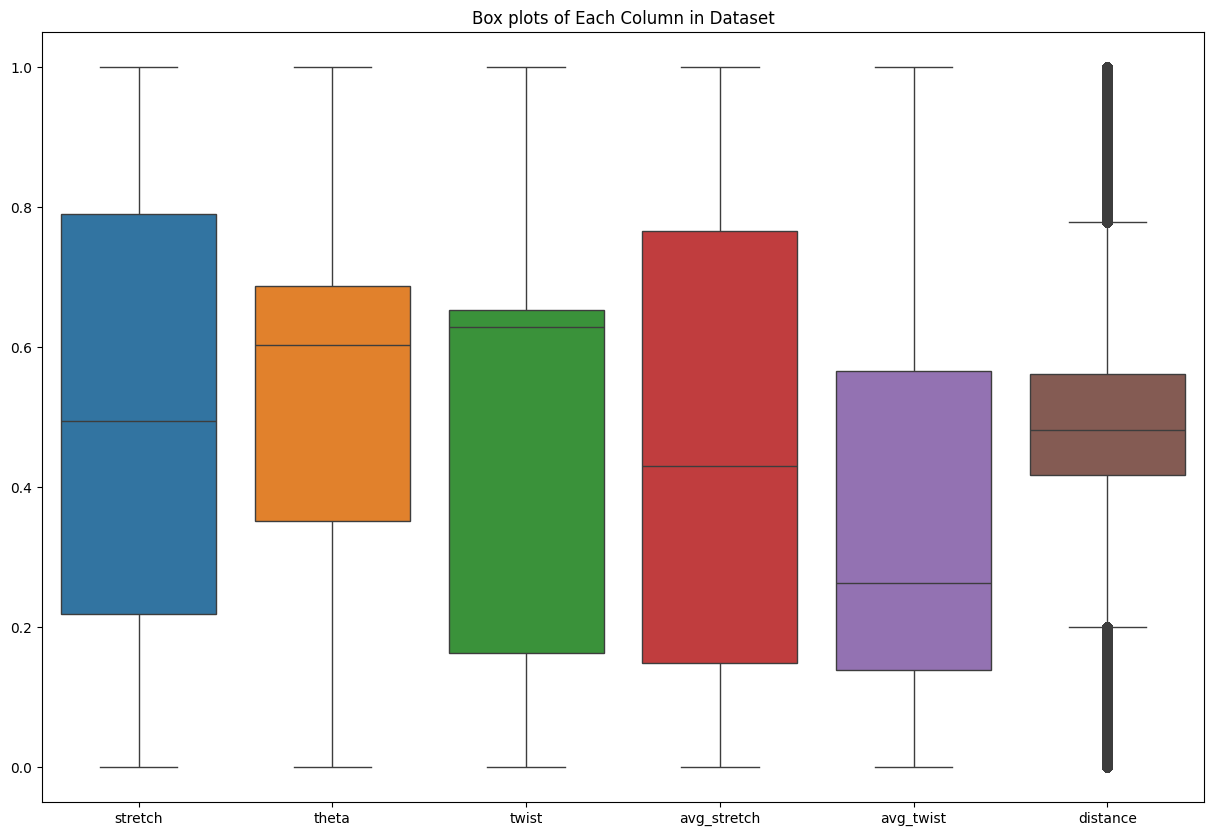

In [10]:
plot_boxplots(data=df_normalized)

In [11]:
# quantile_transformer = QuantileTransformer(output_distribution='normal')
# df_normalized['twist'] = quantile_transformer.fit_transform(df_normalized[['twist']])

In [12]:
# plot_boxplots(data=df_normalized)

Even though twist distribution is skewed, perhaps it is not a good idea to transform twist since we don't have the domain-knowledge.

# 6/ Bivariate and Multivariate Analysis (on normalized dataset with some outliers removed)

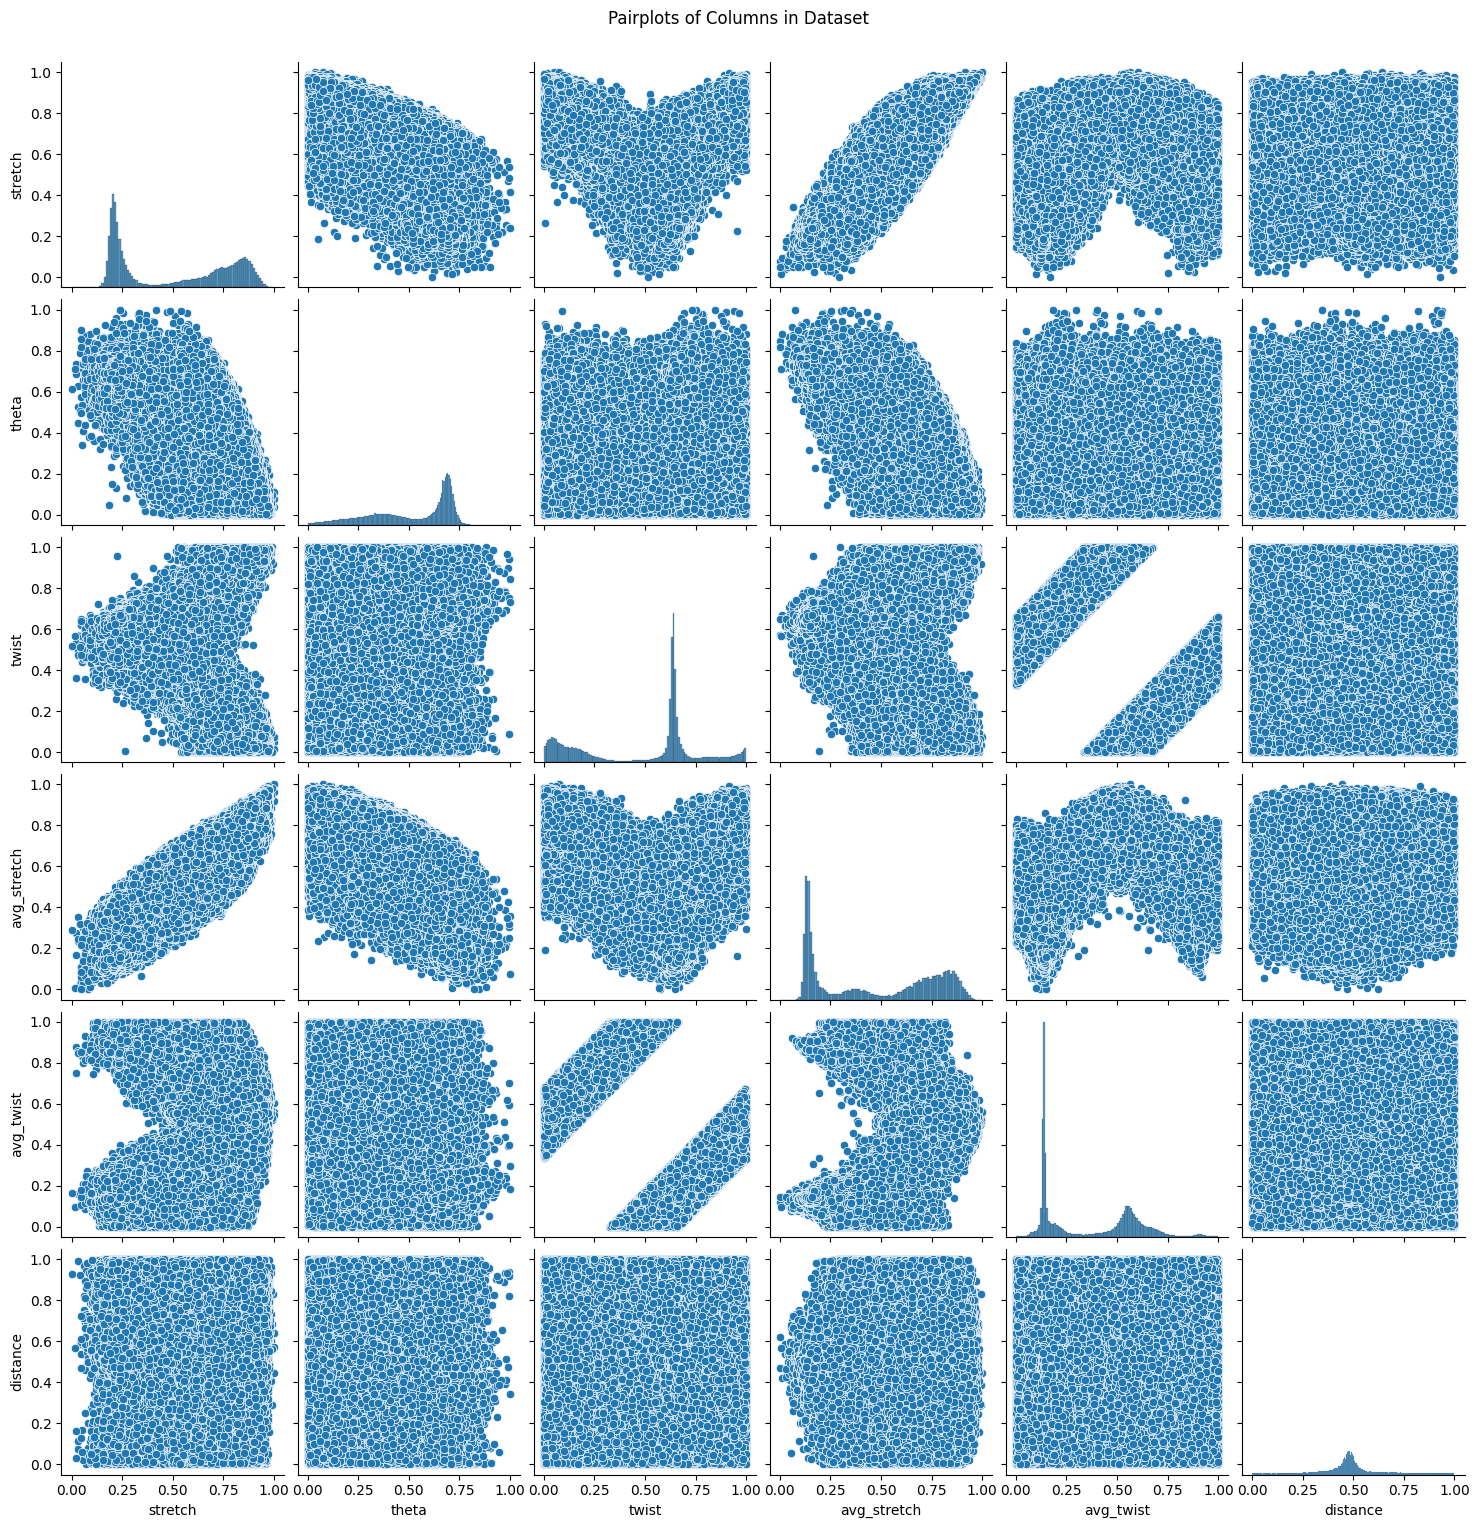

In [13]:
sns.pairplot(df_normalized)
plt.suptitle("Pairplots of Columns in Dataset", y=1.02)
plt.show()

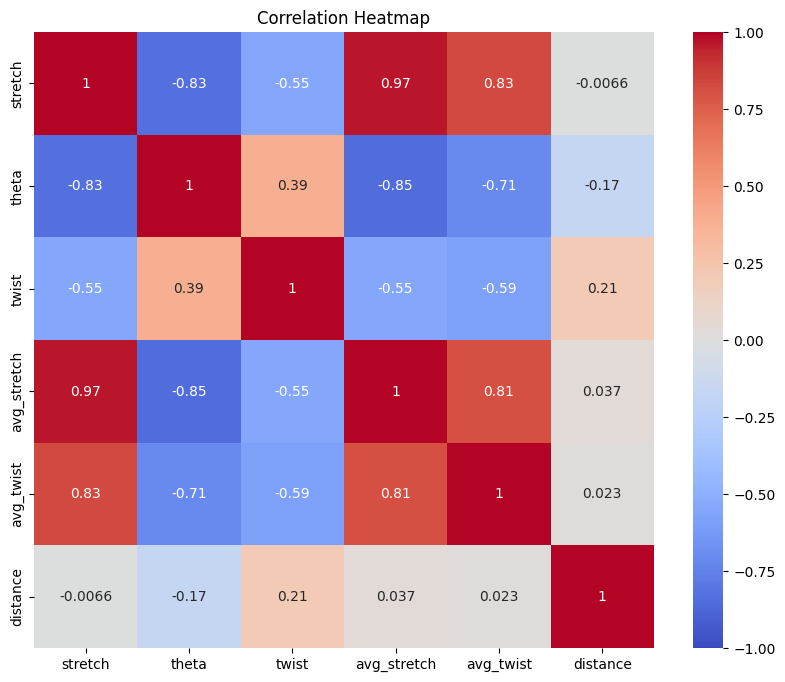

In [14]:
# Pearson's
correlation_matrix = df_normalized.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

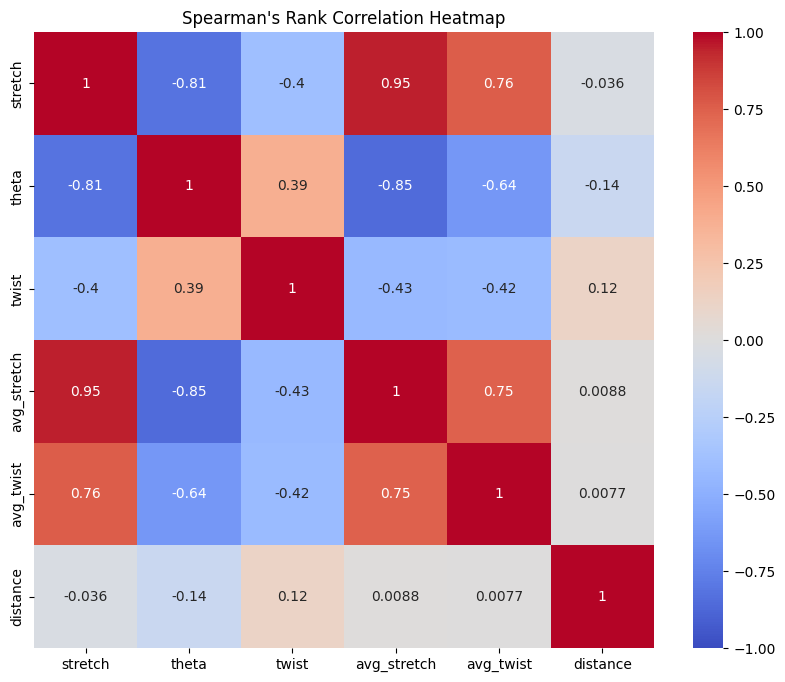

In [15]:
# Compute Spearman's rank correlation for the dataset
spearman_corr = df_normalized.corr(method='spearman')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman's Rank Correlation Heatmap")
plt.show()

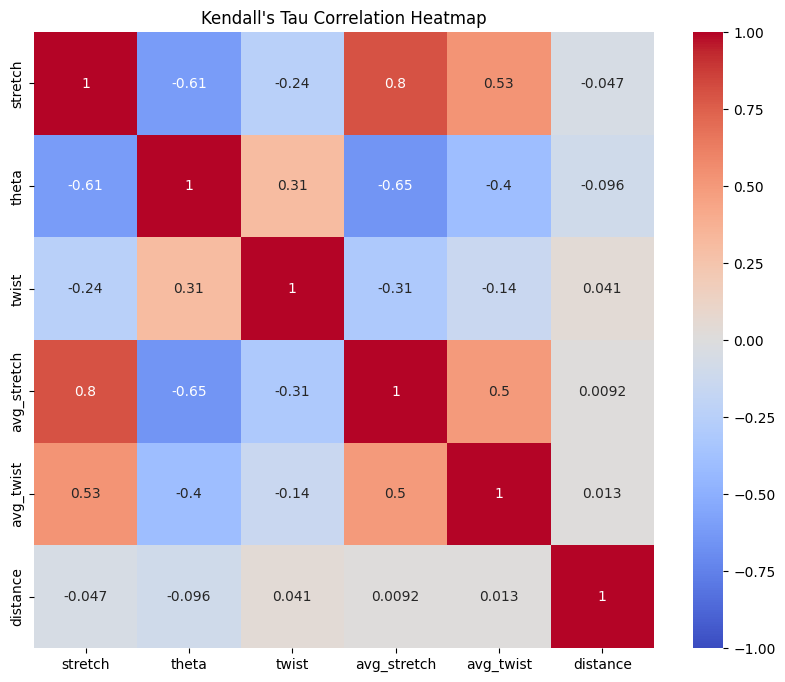

In [16]:
# Compute Kendall's Tau correlation for the dataset
kendall_corr = df_normalized.corr(method='kendall')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Kendall's Tau Correlation Heatmap")
plt.show()

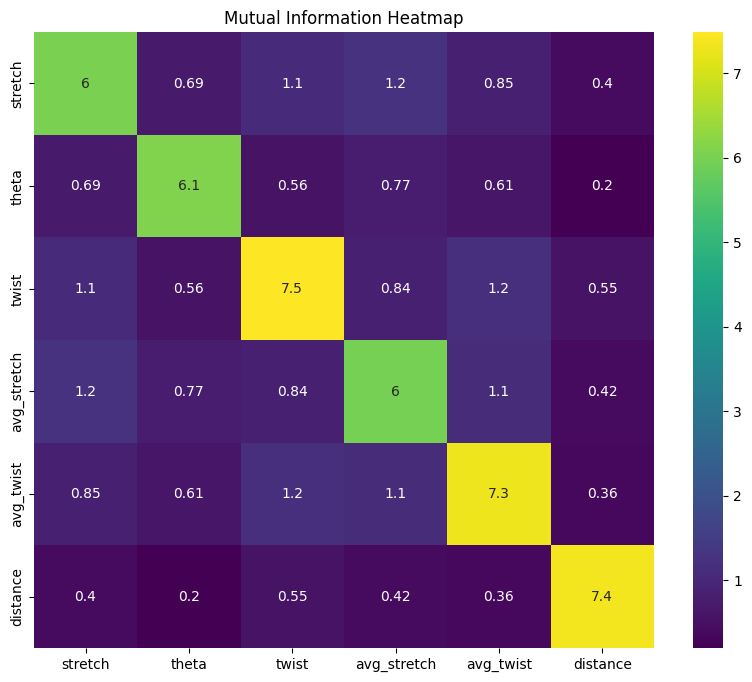

In [17]:
def compute_MI(x, y, discrete_features='auto'):
    return mutual_info_regression(x.values.reshape(-1, 1), y, discrete_features=discrete_features)[0]

# Compute Mutual Information matrix
mi_matrix = pd.DataFrame(index=df_normalized.columns, columns=df_normalized.columns)
for col1 in df_normalized.columns:
    for col2 in df_normalized.columns:
        mi_matrix.loc[col1, col2] = compute_MI(df_normalized[col1], df_normalized[col2])

# Convert the MI matrix to float type
mi_matrix = mi_matrix.astype(float)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mi_matrix, annot=True, cmap='viridis')
plt.title("Mutual Information Heatmap")
plt.show()